<a href="https://colab.research.google.com/github/amandajeng19/NLP-Week2-RAG/blob/main/Retrieval_Augmented_Generation_(RAG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval-Augmented Generation (RAG)
## Introduction
Modern Large Language Models (LLMs), such as GPT, are incredibly powerful for generating coherent text. However, they have some limitations. Retrieval-Augmented Generation (RAG) addresses these limitations by combining retrieval of relevant information with language generation. This approach enables systems to provide accurate, context-aware responses by grounding their output in external knowledge sources.

## Real-World Applications of RAG
**Customer Support:** Providing answers using a company’s FAQs and support documents.

**Chatbots:** Enhancing conversational agents with domain-specific knowledge.

**Question Answering:** Answering user queries using the latest or external knowledge.

## Why Do We Need RAG?
While modern Large Language Models (LLMs), such as GPT, are powerful and capable of generating coherent text, they face some significant limitations:

1. **Knowledge Cutoff:** LLMs are trained on data up to a certain point in time and cannot access newer information after training.

2. **Hallucination:** LLMs may generate plausible-sounding responses that are factually incorrect or fabricated.

3. **Limited Domain Knowledge:** Without additional grounding, LLMs may fail to provide specific, accurate responses in specialized domains.


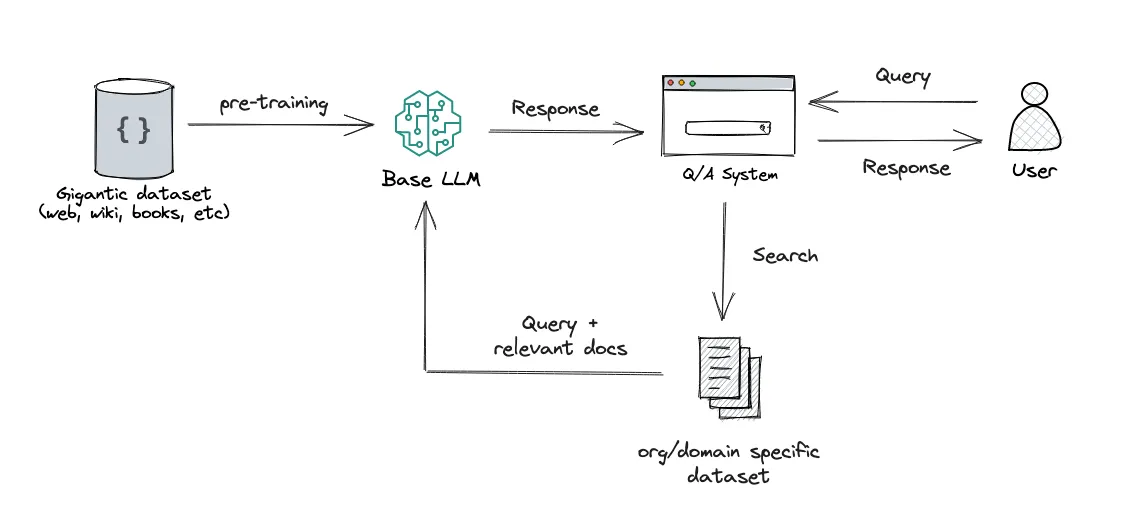


## How Does RAG Work?
RAG addresses these limitations by:

- **Retrieving Relevant Information:** From an external knowledge source (like a database or documents) based on the user's query.

- **Using the Retrieved Information:** As context to generate responses with an LLM.

This approach ensures that the responses are:

- **Grounded in factual data:** By relying on external documents.

- **Domain-specific:** By retrieving knowledge tailored to the query.

## Workflow of RAG
1. **Retriever:** Identifies the most relevant pieces of information for a given query from a knowledge base using dense embeddings or other search methods.

2. **Generator:** Combines the retrieved context with the query and generates a response using a language model.

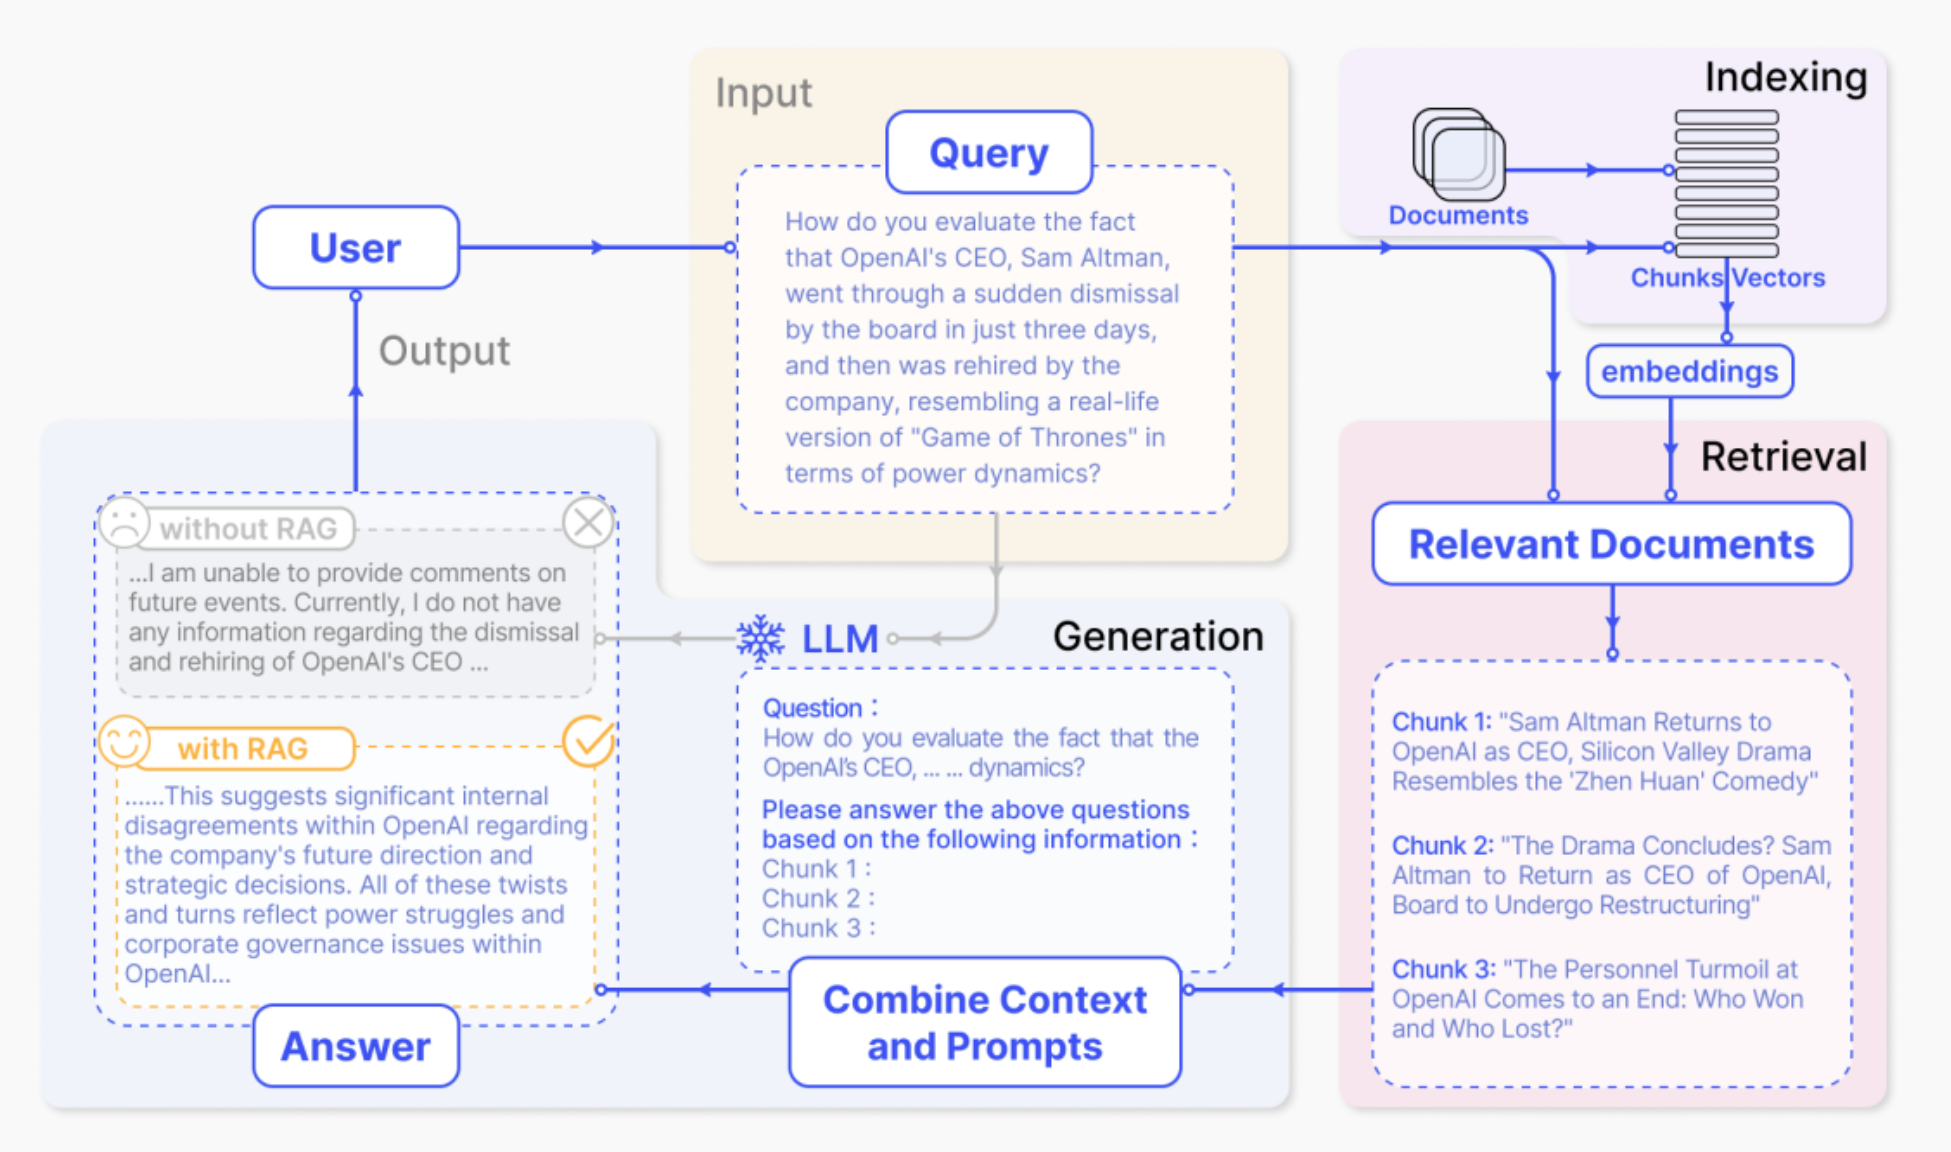

In this notebook, you will:

1. Learn the basic principles of RAG.
2. Ask an LLM a question without RAG to see how it responds with its pre-trained knowledge.
3. Build a simple indexing system to retrieve relevant information for a query.
4. Integrate retrieval and generation to produce better, grounded responses.
5. Compare responses generated with and without RAG to understand its benefits.





# Install Dependencies
Install libraries required for the project:

In [1]:
!pip install transformers sentence-transformers -q


# Import Necessary Libraries

In [2]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Step 1: Ask LLM Without RAG

In [3]:
# Load a pre-trained language model for text generation
llm = pipeline('text-generation', model='gpt2')  # A lightweight example for demonstration

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
# Ask the model a question
question = "What is RAG?"
response = llm(question, max_length=50, num_return_sequences=1)
print("Response from LLM without RAG:", response[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Response from LLM without RAG: What is RAG? It's an electronic device that generates vibrations in your head to convey vibrations that are audible but don't trigger vibrations. It uses these vibrations to tell the difference between noise created by two objects and the sound coming from inside your


# Step 2: Create a Simple Indexing System

In this step, we will create a **retrieval mechanism** to search for relevant information from a collection of documents. This is the foundation of the **Retriever** component in Retrieval-Augmented Generation (RAG). Here's how it works:

### **Why Do We Need an Indexing System?**
- **Efficiency**: Searching through an entire dataset every time a query is made can be computationally expensive. Indexing speeds up this process by organizing data for quick retrieval.
- **Relevance**: By creating a system that compares the query with the content of the documents, we can find the most relevant information.
- **Foundation of RAG**: The retrieved information from the index will be passed to the language model to generate grounded and specific responses.


### **What is an Index?**
An index is a data structure that allows for fast search and retrieval of information. In the context of RAG, **we use embeddings to represent the content of documents numerically**. This allows us to compute the **similarity** between a query and each document efficiently.

### **Steps to Build the Indexing System**
1. **Define a Knowledge Base (Corpus)**: This is the collection of documents or pieces of information that the system can retrieve.

2. **Generate Dense Embeddings**: Each document is converted into a dense vector representation using a **pre-trained embedding model** (e.g., SentenceTransformers). Dense embeddings capture the semantic meaning of the text, making it easier to find similar content.

3. **Create the Index**: Using pandas for indexing allows you to create a more human-readable representation of the documents and their embeddings, while still enabling retrieval.

4. **Retrieve Context**: When a query is provided, it is converted into an embedding using the same model. The index is queried to find the most relevant documents based on their similarity to the query.


## Prepare a Dataset

In [5]:
# Define a small dataset (corpus) of knowledge
documents = [
    "Retrieval-Augmented Generation (RAG) combines retrieval of relevant documents with text generation to produce more accurate responses.",
    "RAG uses two main components: a retriever to find relevant information and a generator to create responses based on that information.",
    "One advantage of RAG is its ability to provide grounded and fact-based answers by retrieving external knowledge.",
    "The retriever in RAG searches a knowledge base to find documents most similar to the user's query.",
    "The generator in RAG uses a language model to combine retrieved documents with the query to generate a coherent response.",
    "RAG systems are used in applications like chatbots, customer support, and question-answering systems.",
    "A key benefit of RAG is that it reduces hallucination by grounding the responses in retrieved content.",
    "Dense vector embeddings, created using models like SentenceTransformers, help the retriever find relevant documents in RAG."
]


## Generate Dense Embeddings and Build an Index

In [6]:
# Step 2: Create dense embeddings for the documents
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # A lightweight model for embedding
embeddings = embedding_model.encode(documents)  # Generate embeddings

# Step 3: Create a pandas DataFrame for indexing
# Combine documents and embeddings in a DataFrame
df = pd.DataFrame({
    "Document": documents,
    "Embedding": list(embeddings)  # Store embeddings as lists for easier handling
})

# Display the DataFrame
print("Indexed Documents:")
print(df.head())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Indexed Documents:
                                            Document  \
0  Retrieval-Augmented Generation (RAG) combines ...   
1  RAG uses two main components: a retriever to f...   
2  One advantage of RAG is its ability to provide...   
3  The retriever in RAG searches a knowledge base...   
4  The generator in RAG uses a language model to ...   

                                           Embedding  
0  [-0.08195891, 0.039505333, 0.0076049003, 0.075...  
1  [-0.08948798, 0.0728827, 0.0033799387, 0.00740...  
2  [-0.021163024, 0.053540166, 0.021180235, 0.012...  
3  [-0.015482078, 0.07263195, -0.029823616, 0.016...  
4  [-0.12042142, 0.08214435, -0.0061354, 0.072079...  


In [7]:
df

Document  \
0  Retrieval-Augmented Generation (RAG) combines ...   
1  RAG uses two main components: a retriever to f...   
2  One advantage of RAG is its ability to provide...   
3  The retriever in RAG searches a knowledge base...   
4  The generator in RAG uses a language model to ...   
5  RAG systems are used in applications like chat...   
6  A key benefit of RAG is that it reduces halluc...   
7  Dense vector embeddings, created using models ...   

                                           Embedding  
0  [-0.08195891, 0.039505333, 0.0076049003, 0.075...  
1  [-0.08948798, 0.0728827, 0.0033799387, 0.00740...  
2  [-0.021163024, 0.053540166, 0.021180235, 0.012...  
3  [-0.015482078, 0.07263195, -0.029823616, 0.016...  
4  [-0.12042142, 0.08214435, -0.0061354, 0.072079...  
5  [-0.0988403, 0.024809139, 0.008629412, -0.0414...  
6  [-0.029951712, 0.08498377, 0.061228674, -0.020...  
7  [-0.072778285, -0.015695298, 0.023951272, 0.00...

In [8]:
def retrieve_with_pandas(query, top_k=2):
    # Generate embedding for the query
    query_embedding = embedding_model.encode([query])[0]

    # Compute similarity scores (cosine similarity)
    df['Similarity'] = df['Embedding'].apply(lambda x: np.dot(query_embedding, x) /
                                             (np.linalg.norm(query_embedding) * np.linalg.norm(x)))
    # Sort by similarity and return top-k results
    results = df.sort_values(by="Similarity", ascending=False).head(top_k)
    return results[["Document", "Similarity"]]



# Define a function to use RAG
def generate_with_rag(query):
    # Retrieve context
    context = retrieve_with_pandas(query)["Document"]
    # Combine context with query
    input_text = f"Respond the query based on the context. Context: {context} Query: {query}"
    # Use LLM to generate a response
    response = llm(input_text, max_length=150, num_return_sequences=1)
    return response[0]['generated_text']


In [9]:
query = "What are the components of RAG?"
results = retrieve_with_pandas(query, top_k=2)

print("\nQuery:", query)
print("\nTop Retrieved Documents:")
print(results)


Query: What are the components of RAG?

Top Retrieved Documents:
                                            Document  Similarity
1  RAG uses two main components: a retriever to f...    0.722874
5  RAG systems are used in applications like chat...    0.622569


In [10]:
df

# note the similarity score

Document  \
0  Retrieval-Augmented Generation (RAG) combines ...   
1  RAG uses two main components: a retriever to f...   
2  One advantage of RAG is its ability to provide...   
3  The retriever in RAG searches a knowledge base...   
4  The generator in RAG uses a language model to ...   
5  RAG systems are used in applications like chat...   
6  A key benefit of RAG is that it reduces halluc...   
7  Dense vector embeddings, created using models ...   

                                           Embedding  Similarity  
0  [-0.08195891, 0.039505333, 0.0076049003, 0.075...    0.299929  
1  [-0.08948798, 0.0728827, 0.0033799387, 0.00740...    0.722874  
2  [-0.021163024, 0.053540166, 0.021180235, 0.012...    0.504489  
3  [-0.015482078, 0.07263195, -0.029823616, 0.016...    0.314352  
4  [-0.12042142, 0.08214435, -0.0061354, 0.072079...    0.485206  
5  [-0.0988403, 0.024809139, 0.008629412, -0.0414...    0.622569  
6  [-0.029951712, 0.08498377, 0.061228674, -0.020...    0.622523  
7  [-0.072778285, -0.015695298, 0.023951272, 0.00...    0.390052

# Step 3: Ask Question with RAG

In [11]:
# Ask the same question with RAG
response_rag = generate_with_rag(question)
print("****")
print("Response from LLM with RAG:", response_rag)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


****
Response from LLM with RAG: Respond the query based on the context. Context: 5    RAG systems are used in applications like chat...
1    RAG uses two main components: a retriever to f...
Name: Document, dtype: object Query: What is RAG? This tool provides a quick summary of each of the RAG commands to retrieve the key from the document and DAT fields.


# Step 4: Compare the Results

In [12]:
# Display both responses for comparison
print("Without RAG:", response[0]['generated_text'])
print("****")
print("With RAG:", response_rag)

Without RAG: What is RAG? It's an electronic device that generates vibrations in your head to convey vibrations that are audible but don't trigger vibrations. It uses these vibrations to tell the difference between noise created by two objects and the sound coming from inside your
****
With RAG: Respond the query based on the context. Context: 5    RAG systems are used in applications like chat...
1    RAG uses two main components: a retriever to f...
Name: Document, dtype: object Query: What is RAG? This tool provides a quick summary of each of the RAG commands to retrieve the key from the document and DAT fields.


In [ ]:
# You could also create keywords for your context, and embed the keyword rather than the whole document.
# You could also embed questions that could be answered by each document. This would be really good for Q&A chatbots.

## **Optional Extensions**

Here are some exercises:

1. Add More Documents: Expand the corpus with domain-specific documents (e.g., healthcare or education) and build a question-answering system tailored to that domain.

2. Enhance Retrieval: Modify the retrieval function to use more complex strategies.

3. Fine-Tune the Generator: Fine-tune the generation model on your dataset for more accurate, context-aware responses.

4. Use LLaMA for Generation: Replace GPT with LLaMA (e.g., `meta-llama/Llama-2-7b-hf`) for response generation.
